In [141]:
import networkx
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from pyod.models.lof import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

In [142]:
NUM_NEIGHBORS = 'num_neighbors'
NUM_EDGES = 'egonet_num_edges'
EGONET_WEIGHT = 'egonet_weight'
EGONET_PRINCIPAL_EIGVAL = 'egonet_principal_eigval'

In [ ]:
def init_edge_freq_graph(fileName):
    G = networkx.Graph()
    with open(fileName) as dataset:
        for line in dataset:
            if line[0] == '#':
                continue
            edge = list(map(int, line.split()))
            if not G.has_edge(edge[0], edge[1]):
                G.add_edge(edge[0], edge[1], weight=0)
            G[edge[0]][edge[1]]['weight'] += 1
    return G

def init_weighted_graph(fileName):
    G = networkx.Graph()
    with open(fileName) as dataset:
        for line in dataset:
            if line[0] == '#':
                continue
            edge = list(map(int, line.split()))
            if not G.has_edge(edge[0], edge[1]):
                G.add_edge(edge[0], edge[1], weight=0)
            G[edge[0]][edge[1]]['weight'] += edge[2]
    return G

def extract_graph_features(G):
    nodes, nodeNumNeighbors, nodeEgonetNumEdges, nodeEgonetWeight, nodeEgonetPrincipalEigVal = [], [], [], [], []
    for node in G.nodes:
        nodes.append(node)
        egonet = networkx.ego_graph(G, node)
        nodeNumNeighbors.append(egonet.number_of_nodes())
        nodeEgonetNumEdges.append(egonet.number_of_edges())
        nodeEgonetWeight.append(sum(
            [G[edge[0]][edge[1]]['weight'] for edge in egonet.edges]
        ))
        adjmat = networkx.adjacency_matrix(egonet).toarray()
        nodeEgonetPrincipalEigVal.append(np.max(np.linalg.eigh(adjmat)[0]))

    return {
        'nodes': nodes,
        'num_neighbors': np.array(nodeNumNeighbors).reshape(-1, 1),
        'egonet_num_edges': np.array(nodeEgonetNumEdges).reshape(-1, 1),
        'egonet_weight': np.array(nodeEgonetWeight).reshape(-1, 1),
        'egonet_principal_eigval': np.array(nodeEgonetPrincipalEigVal).reshape(-1, 1),
    }

def fit_lr(x, y):
    model = LinearRegression()
    model.fit(x, y)
    
    C = np.exp(model.intercept_)
    theta = model.coef_[0]
    return C, theta

def out_line_score(x, y, C, theta):
    preds = C * x**theta
    ratios = np.maximum(y, preds) / np.minimum(y, preds)
    scores = ratios * np.log(np.abs(y-preds)+1)

    normalized = MinMaxScaler().fit_transform(scores.reshape(-1, 1)).flatten()

    return normalized

def lof_score(x, y):
    x_train = np.hstack((x, y))
    print(x_train)
    model = IsolationForest(n_jobs=-1)
    model.fit(x_train)
    print(model.decision_function(x_train))
    scores = model.score_samples(x_train)

    normalized = MinMaxScaler().fit_transform(scores.reshape(-1, 1)).flatten()

    return normalized

def eval_power_law(x, y, xlabel, ylabel, title, power_law_min=None, power_law_max=None, with_lof=False):
    # We want to find C and theta for the power law y ~ x^theta <=> y = C*x^theta
    # We can perform linear regression on log-scaled x and y:
    #       log(y) = log(C * x^theta) = log(C) + theta*log(x)
    x_log = np.log(x)
    y_log = np.log(y)
    x_log_range = np.array([np.min(x), np.max(x)])

    C, theta = fit_lr(x_log, y_log)

    

    ols = out_line_score(x, y, C, theta)
    lofs = lof_score(x_log, y_log) if with_lof else 0
    scores = ols + lofs

    threshold = np.quantile(scores, 0.9995)
    outliers = scores>threshold
    x_log = x_log.flatten()
    y_log = y_log.flatten()
    print(outliers)
    print(x_log)

    plt.scatter(x, y, s=1)
    plt.loglog(np.sort(x), C*np.sort(x)**theta, c='red', label='best-fit line')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(x[outliers], y[outliers], marker='^', label='outliers')
    plt.title(title)
    plt.legend()
    plt.show()

    return scores

In [148]:
graph = init_edge_freq_graph('email-Enron.txt')
features = extract_graph_features(graph)

[False False False ... False False False]
[0.69314718 4.26267988 0.69314718 ... 1.09861229 0.69314718 0.69314718]


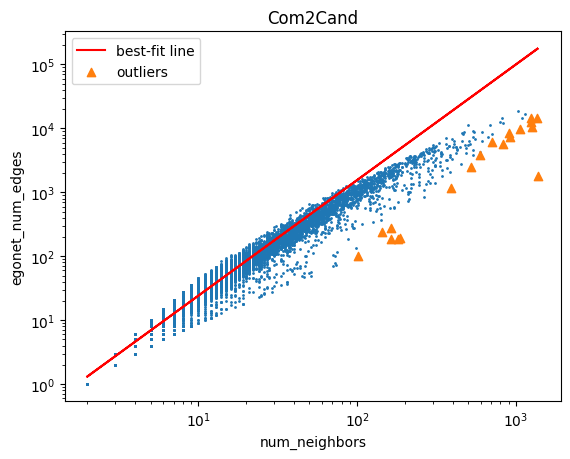

[False False False ... False False False]
[0.         4.63472899 0.         ... 1.09861229 0.         0.        ]


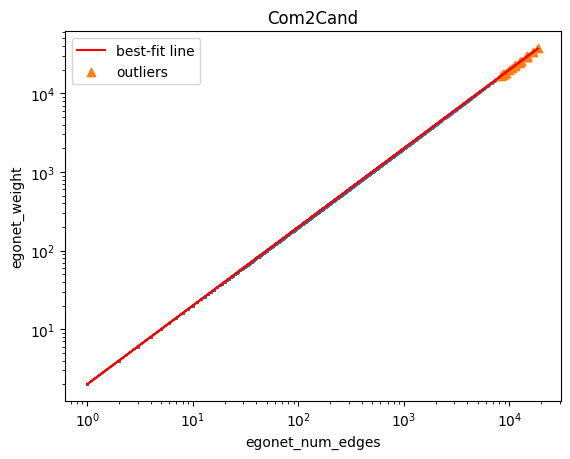

[False False False ... False False False]
[0.69314718 5.32787617 0.69314718 ... 1.79175947 0.69314718 0.69314718]


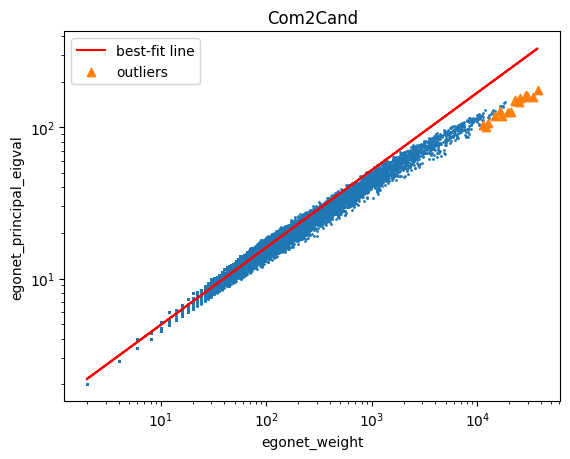

array([0.01659613, 0.22489042, 0.01659613, ..., 0.01893332, 0.01659613,
       0.01659613])

In [149]:
eval_power_law(features['num_neighbors'], features['egonet_num_edges'], 'num_neighbors', 'egonet_num_edges', 'Enron')
eval_power_law(features['egonet_num_edges'], features['egonet_weight'], 'egonet_num_edges', 'egonet_weight', 'Enron')
eval_power_law(features['egonet_weight'], features['egonet_principal_eigval'], 'egonet_weight', 'egonet_principal_eigval', 'Enron')

In [146]:
graph = init_weighted_graph('Com2Cand.txt')
features = extract_graph_features(graph)

[False False False ... False False False]
[4.20469262 5.43807931 4.56434819 ... 0.69314718 3.66356165 0.69314718]


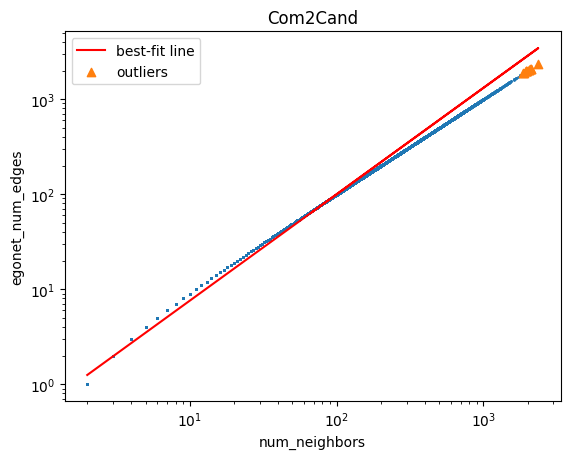

[False False False ... False False False]
[4.18965474 5.433722   4.55387689 ... 0.         3.63758616 0.        ]


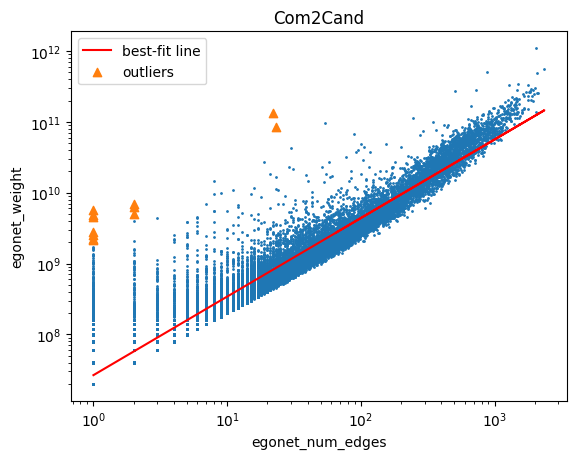

[False False False ... False False False]
[21.4082853  23.05127377 21.66075867 ... 19.01151444 22.68075337
 18.4237273 ]


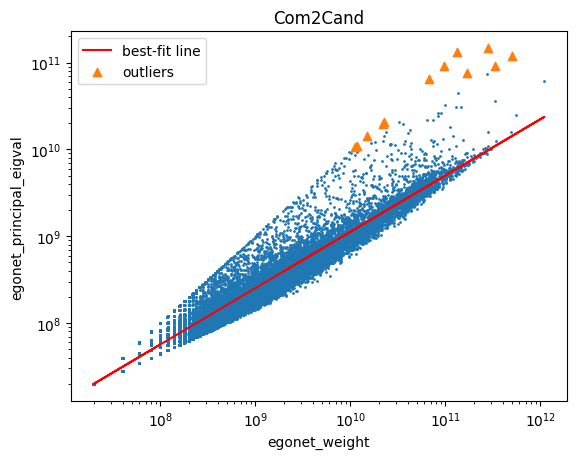

array([0.03391133, 0.026184  , 0.04187782, ..., 0.06049135, 0.05660993,
       0.04444709])

In [ ]:
# Notice that since we have a bipartite 1-step neighborhood this is just plotting log(n) and log(n-1)
eval_power_law(features['num_neighbors'], features['egonet_num_edges'], 'num_neighbors', 'egonet_num_edges')
eval_power_law(features['egonet_num_edges'], features['egonet_weight'], 'egonet_num_edges', 'egonet_weight')
eval_power_law(features['egonet_weight'], features['egonet_principal_eigval'], 'egonet_weight', 'egonet_principal_eigval')